## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Use the found points to calculate distortion coefficients to distort image

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    """
    A function that takes an image, object points, and image points 
    performs the camera calibration, image distortion correction 
    and returns the undistorted image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Test Function cal_undistort

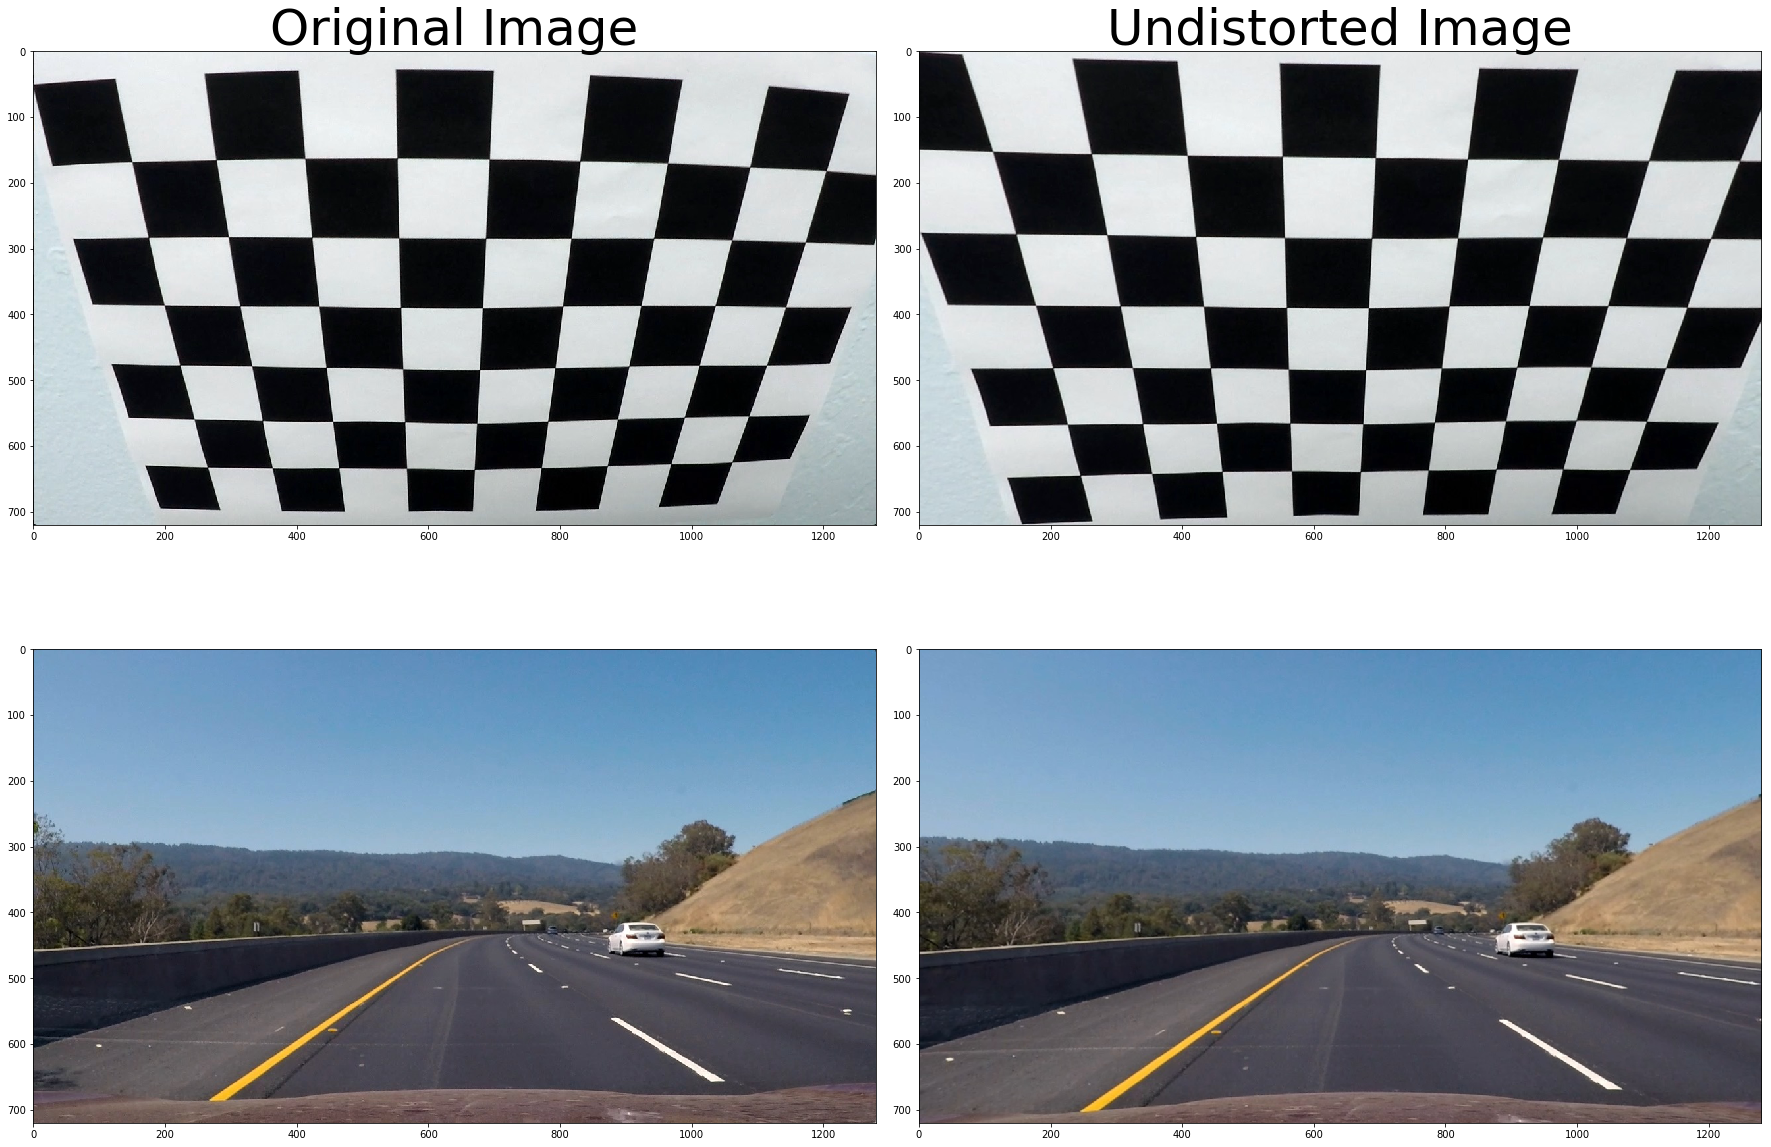

In [35]:
%matplotlib inline

def bgr2rgb(img):
    b,g,r = cv2.split(img)
    return cv2.merge((r,g,b))

test_image_1 = cv2.imread('./camera_cal/calibration2.jpg')
undistorted_1 = cal_undistort(test_image_1, objpoints, imgpoints)

test_image_2 = cv2.imread('./test_images/test3.jpg')
undistorted_2 = cal_undistort(test_image_2, objpoints, imgpoints)

test_image_3 = cv2.imread('./test_images/test4.jpg')

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(24, 18))
f.tight_layout()
ax1[0].imshow(test_image_1)
ax1[0].set_title('Original Image', fontsize=50)
ax1[1].imshow(undistorted_1)
ax1[1].set_title('Undistorted Image', fontsize=50)
ax2[0].imshow(bgr2rgb(test_image_2))
ax2[1].imshow(bgr2rgb(undistorted_2))
cv2.imwrite('./output_images/undistorted_img.png', undistorted_2)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective Transform

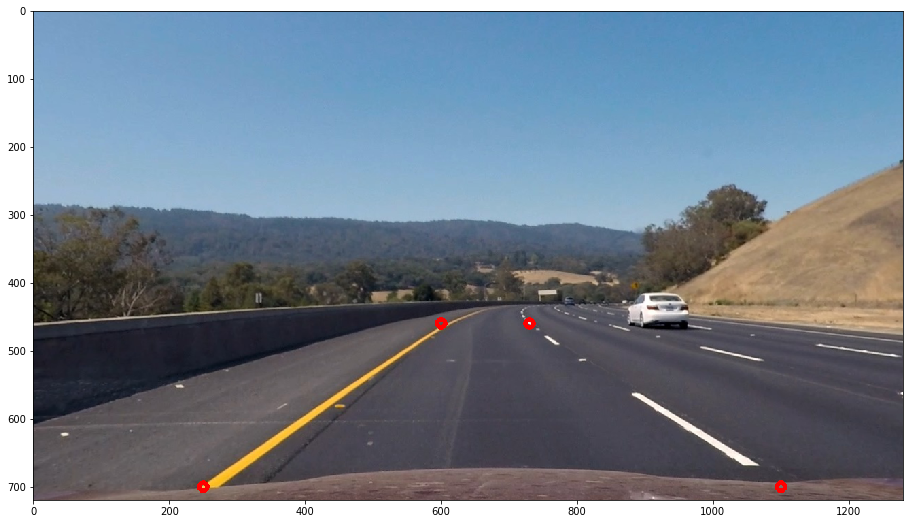

In [51]:
def draw_points(img, points, color=(0,0,255), size=6):
    result = np.copy(img)
    for p in points:
        cv2.circle(result, p, size, color, thickness=size)
    return result
src = [(600, 460), (250, 700), (1100, 700), (730, 460)]
dst = [(320,0), (320,720),(960,720),(960,0)]
plt.figure(figsize=(24,9))
points_img = draw_points(undistorted_2, src)
plt.imshow(bgr2rgb(points_img))
cv2.imwrite('./output_images/point_img.png', points_img)
plt.show()

In [49]:
# perspective transform
def perspective_trans(img):
    src = [(600, 460), (250, 700), (1100, 700), (730, 460)]
    dst = [(320,0), (320,720),(960,720),(960,0)]
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    warped = cv2.warpPerspective(img, M, dsize = (img.shape[1],img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped, M, Minv

### Test perspective transformation

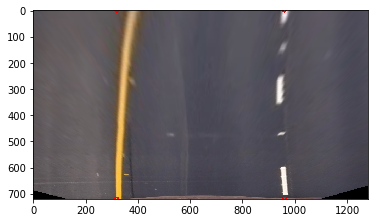

In [67]:
# show the transformation of original image
warped_img, M, Minv = perspective_trans(undistorted_2)
out_img = draw_points(warped_img, dst)
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
cv2.imwrite('./output_images/transformed_img.png', out_img)
plt.show()

## Create a thresholded binary image

In [41]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(sobel_abs*255/np.max(sobel_abs))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    binary_output = sxbinary
    return binary_output
    
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(gray)
    mask[(grad_direction>thresh[0]) & (grad_direction<thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = mask
    return binary_output


def hls_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    yellow_low = np.array([0,90,100])
    yellow_high = np.array([50,180,255])
    white_low = np.array([0,180,0])
    white_high = np.array([255,255,255])
    
    yellow_mask = cv2.inRange(hls, np.array(yellow_low), np.array(yellow_high))
    white_mask = cv2.inRange(hls, np.array(white_low), np.array(white_high))
    binary_output = cv2.bitwise_or(yellow_mask, white_mask)
    binary_output[binary_output==255] = 1
    return binary_output

### Test Function binary_img

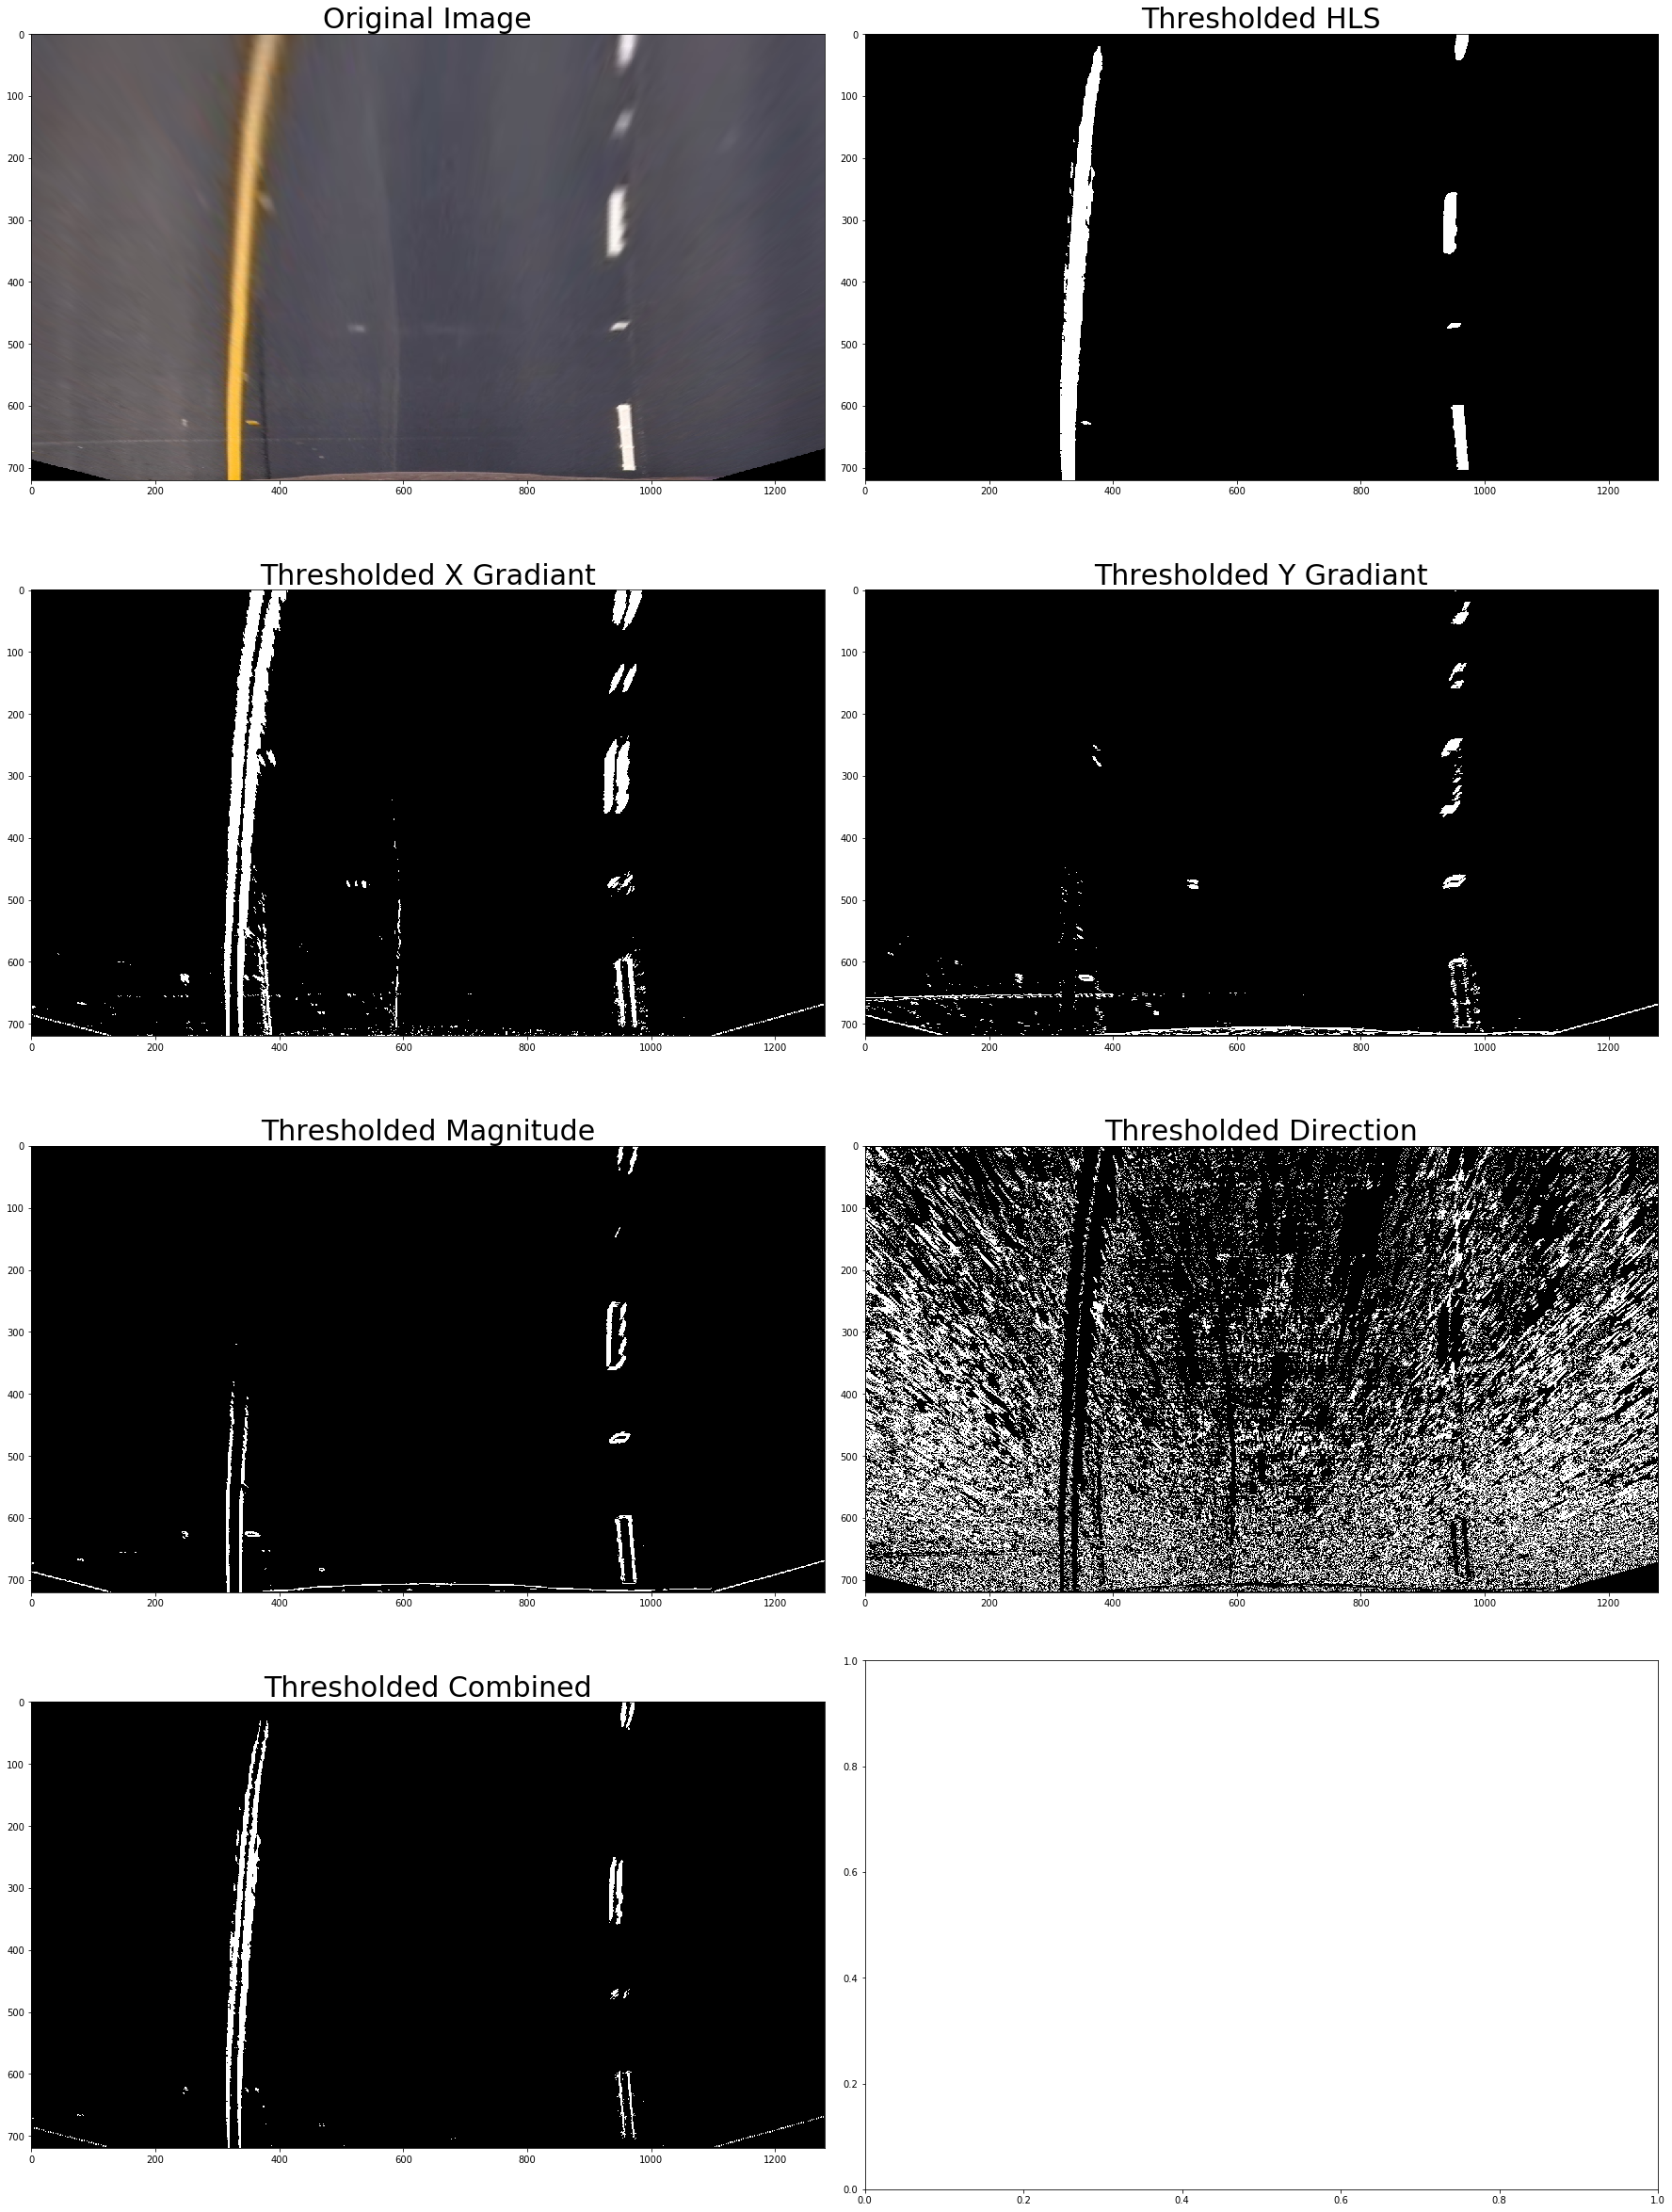

In [57]:
image = warped_img
#image = undistorted_2

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 230))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 230))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 150))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
hls_binary = hls_threshold(image)

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, axes = plt.subplots(4, 2, figsize=(24, 36))
f.tight_layout()
axes[0][0].imshow(bgr2rgb(image))
axes[0][0].set_title('Original Image', fontsize=30)
axes[0][1].imshow(hls_binary, cmap='gray')
axes[0][1].set_title('Thresholded HLS', fontsize=30)
axes[1][0].imshow(gradx, cmap='gray')
axes[1][0].set_title('Thresholded X Gradiant', fontsize=30)
axes[1][1].imshow(grady, cmap='gray')
axes[1][1].set_title('Thresholded Y Gradiant', fontsize=30)
axes[2][0].imshow(mag_binary, cmap='gray')
axes[2][0].set_title('Thresholded Magnitude', fontsize=30)
axes[2][1].imshow(dir_binary, cmap='gray')
axes[2][1].set_title('Thresholded Direction', fontsize=30)
axes[3][0].imshow(combined, cmap='gray')
axes[3][0].set_title('Thresholded Combined', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Final Threshold Function

In [58]:
def threshold(img):
    hls_binary = hls_threshold(img)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    combined = np.zeros_like(hls_binary)
    combined[((gradx == 1) & (hls_binary == 1)) | (mag_binary == 1)] = 1
    return combined

### Transform Warped Image

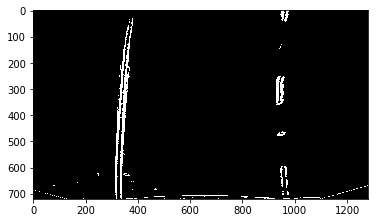

In [68]:
binary_warped = threshold(warped_img)
plt.imshow(binary_warped, cmap='gray')
cv2.imwrite('./output_images/threshold_img.png', binary_warped*255)
plt.show()

## Finding Lane

### Peaks in a Histogram

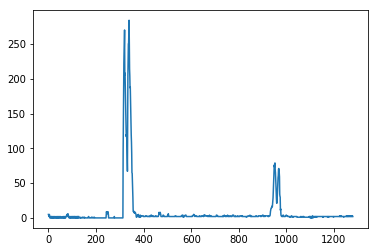

In [60]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

### Sliding Windows

In [12]:
def search_lanes_init(binary_warped):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds

### Visualization

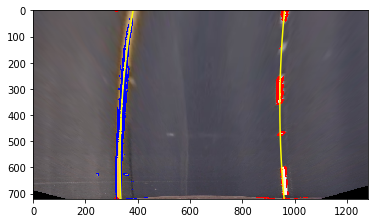

In [69]:
left_fit, right_fit, left_lane_inds, right_lane_inds = search_lanes_init(binary_warped)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(bgr2rgb(out_img))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Search Lanes with previous frame data

In [14]:
def search_lanes_with_history(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds
    
    

### Visualization

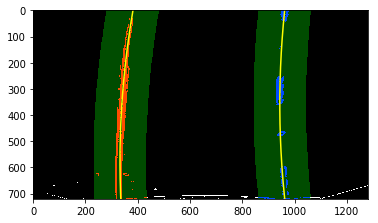

In [70]:
left_fit, right_fit, left_lane_inds, right_lane_inds = search_lanes_with_history(binary_warped, left_fit, right_fit)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
    
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))
# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('./output_images/poly_lines.png')
plt.show()

### Recent Frames Data

In [16]:
MAX_FRAMES = 5
left_fit_hist = []
right_fit_hist = []

def add_frame_data(left_fit, right_fit):
    global left_fit_hist
    global right_fit_hist
    if len(left_fit_hist) >= MAX_FRAMES:
        left_fit_hist = left_fit_hist[1:]
        right_fit_hist = right_fit_hist[1:]
    left_fit_hist.append(left_fit)
    right_fit_hist.append(right_fit)
    
def get_smoothed_data():
    global left_fit_hist
    global right_fit_hist
    left_fit = np.mean(left_fit_hist, axis=0)
    right_fit = np.mean(right_fit_hist, axis=0)
    return left_fit, right_fit

def last_frame_data():
    global left_fit_hist
    global right_fit_hist
    if len(left_fit_hist) > 0:
        return left_fit_hist[len(left_fit_hist)-1], right_fit_hist[len(right_fit_hist)-1]
    else:
        return None, None

def reset_history():
    global left_fit_hist
    global right_fit_hist
    left_fit_hist = []
    right_fit_hist = []

### Final Search Lanes Function

In [17]:
def search_lanes(binary_warped, left_fit=None, right_fit=None):
    if left_fit is not None and right_fit is not None:
        return search_lanes_with_history(binary_warped, left_fit, right_fit)
    else:
        return search_lanes_init(binary_warped)

### Warp Lane Overlay Back

In [18]:
def warp_lane_back(binary_warped, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), 255)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (warp_zero.shape[1], warp_zero.shape[0]),flags = cv2.INTER_LINEAR) 
    return newwarp

In [19]:
def add_overlay(origin, overlay):
    zeros_img = np.zeros_like(overlay).astype(np.uint8)
    color_result = np.dstack((zeros_img, overlay, zeros_img))
    color_result = cv2.addWeighted(origin, 1, color_result, 0.3, 0)
    return color_result

### Testing

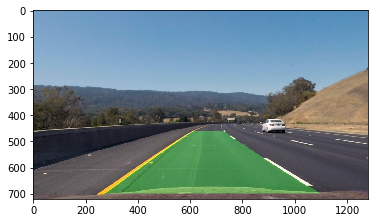

In [71]:
original = undistorted_2
left_fit, right_fit, left_lane_inds, right_lane_inds = search_lanes(binary_warped)
result = warp_lane_back(binary_warped, left_fit, right_fit, Minv)
color_result = add_overlay(original, result)
plt.imshow(bgr2rgb(color_result))
cv2.imwrite('./output_images/lane_overlay.png', color_result)
plt.show()

## Calculate Curvature and Distance

### Meters per pixel

In [21]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/640 # meters per pixel in x dimension

### Curvature Calculation

In [22]:
def calc_curvature(left_fit, right_fit, ploty):
    global ym_per_pix
    global xm_per_pix
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    y_eval = np.max(ploty)*ym_per_pix
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

#### Testing calc_curvature function

In [23]:
left_curverad, right_curverad = calc_curvature(left_fit, right_fit, ploty)
print(left_curverad, 'm', right_curverad, 'm')

4230.856995902472 m 3331.335785785483 m


### Distance Calculation

In [24]:
def calc_distance(left_fit, right_fit, ploty):
    global xm_per_pix
    y_eval = np.max(ploty)
    left_lane_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    distance_from_center = (1280 / 2 - (left_lane_bottom + right_lane_bottom) / 2) * xm_per_pix
    return distance_from_center

#### Testing calc_distance function

In [25]:
dist = calc_distance(left_fit, right_fit, ploty)
print(dist, 'm')

0.14647599137919104 m


### Paint Measurement

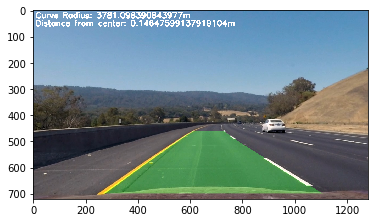

In [26]:
def paint_measurement(img, curv, dist):
    cv2.putText(img, 'Curve Radius: ' + str(curv) + 'm', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    cv2.putText(img, 'Distance from center: ' + str(dist) + 'm', (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    return img

curv = (left_curverad + right_curverad) / 2
result = paint_measurement(color_result, curv, dist)
plt.imshow(bgr2rgb(result))
plt.show()

## Sanity Check

In [27]:
def is_parallel(left_fit, right_fit, ploty):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    dist = right_fitx - left_fitx
    return(np.std(dist)<10)
    
def sanity_check(left_fit, right_fit, ploty):
    return is_parallel(left_fit, right_fit, ploty)

In [28]:
is_parallel(left_fit, right_fit, ploty)

True

## Final Pipeline

In [29]:
def pipeline(img):
    processing_img = np.copy(img)
    
    processing_img = cal_undistort(processing_img, objpoints, imgpoints)
    
    processing_img, M, Minv = perspective_trans(processing_img)
    
    processing_img = threshold(processing_img)
    
    left_fit, right_fit = last_frame_data()
    ploty = np.linspace(0, processing_img.shape[0]-1, processing_img.shape[0] )
    left_fit, right_fit, left_lane_inds, right_lane_inds = search_lanes(processing_img, left_fit, right_fit)
    if(sanity_check(left_fit, right_fit, ploty)):
        add_frame_data(left_fit, right_fit)
    left_fit, right_fit = get_smoothed_data()
    
    processing_img = warp_lane_back(processing_img, left_fit, right_fit, Minv)
    
    processing_img = add_overlay(img, processing_img)
    
    left_curverad, right_curverad = calc_curvature(left_fit, right_fit, ploty)
    curv = (left_curverad + right_curverad) / 2
    dist = calc_distance(left_fit, right_fit, ploty)
    processing_img = paint_measurement(processing_img, curv, dist)
    
    return processing_img
    

#### Testing Pipeline

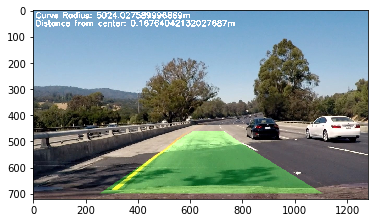

In [30]:
reset_history()
result = pipeline(test_image_3)
plt.imshow(bgr2rgb(result))
plt.show()

In [31]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile("./project_video_result.mp4", audio=False)

[MoviePy] >>>> Building video ./project_video_result.mp4
[MoviePy] Writing video ./project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:16<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_result.mp4 

Wall time: 13min 17s
